In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import norm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class BlackScholesNN(nn.Module):
    def __init__(self):
        super(BlackScholesNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, S):
        inputs = torch.cat([t, S], dim=1)
        return self.net(inputs)


In [4]:
model = BlackScholesNN().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [5]:
# Paramètres du modèle Black-Scholes
r = torch.tensor(0.05, device=device)  # Taux d'intérêt sans risque
sigma = torch.tensor(0.2, device=device)  # Volatilité
K = torch.tensor(100, device=device)  # Prix d'exercice
T = torch.tensor(2, device=device)  # Maturité

# Grille de temps et de prix de l'actif
t = torch.linspace(0, T, 100, device=device).view(-1, 1)
S = torch.linspace(20, 200, 100, device=device).view(-1, 1)
t, S = torch.meshgrid(t[:, 0], S[:, 0], indexing='ij')
t, S = t.reshape(-1, 1), S.reshape(-1, 1)

In [6]:
# Les variables t et S doivent être déclarées pour le calcul de gradient
t.requires_grad = True
S.requires_grad = True

train_loss_record = []

for epoch in range(10001):
    optimizer.zero_grad()
    V = model(t, S)
    V_t = torch.autograd.grad(V, t, torch.ones_like(V, device=device), create_graph=True)[0]
    V_s = torch.autograd.grad(V, S, torch.ones_like(V, device=device), create_graph=True)[0]
    V_ss = torch.autograd.grad(V_s, S, torch.ones_like(V_s, device=device), create_graph=True)[0]

    # Formule de Black-Scholes
    f = V_t + 0.5 * sigma**2 * S**2 * V_ss + r * S * V_s - r * V
    loss = torch.mean(f ** 2)

    # Ajout de la condition terminale pour t proche de T
    payoff = torch.maximum(S - K, torch.zeros_like(S, device=device))
    terminal_condition = (t >= 0.95 * T) * (V - payoff) ** 2  # Pénalise les écarts à T
    loss += torch.mean(terminal_condition)

    train_loss_record.append(loss.detach().cpu().numpy())

    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 95.12538146972656
Epoch 500, Loss: 52.33467102050781
Epoch 1000, Loss: 30.85385513305664
Epoch 1500, Loss: 17.058162689208984
Epoch 2000, Loss: 9.534150123596191
Epoch 2500, Loss: 5.469997406005859
Epoch 3000, Loss: 3.2099251747131348
Epoch 3500, Loss: 1.8814215660095215
Epoch 4000, Loss: 1.1602336168289185
Epoch 4500, Loss: 0.7685158252716064
Epoch 5000, Loss: 0.546726405620575
Epoch 5500, Loss: 0.4141348600387573
Epoch 6000, Loss: 0.33121633529663086
Epoch 6500, Loss: 0.28026455640792847
Epoch 7000, Loss: 0.2426551878452301
Epoch 7500, Loss: 0.21758562326431274
Epoch 8000, Loss: 0.20062503218650818
Epoch 8500, Loss: 0.1883237361907959
Epoch 9000, Loss: 0.17915117740631104
Epoch 9500, Loss: 0.17200535535812378
Epoch 10000, Loss: 0.17208188772201538


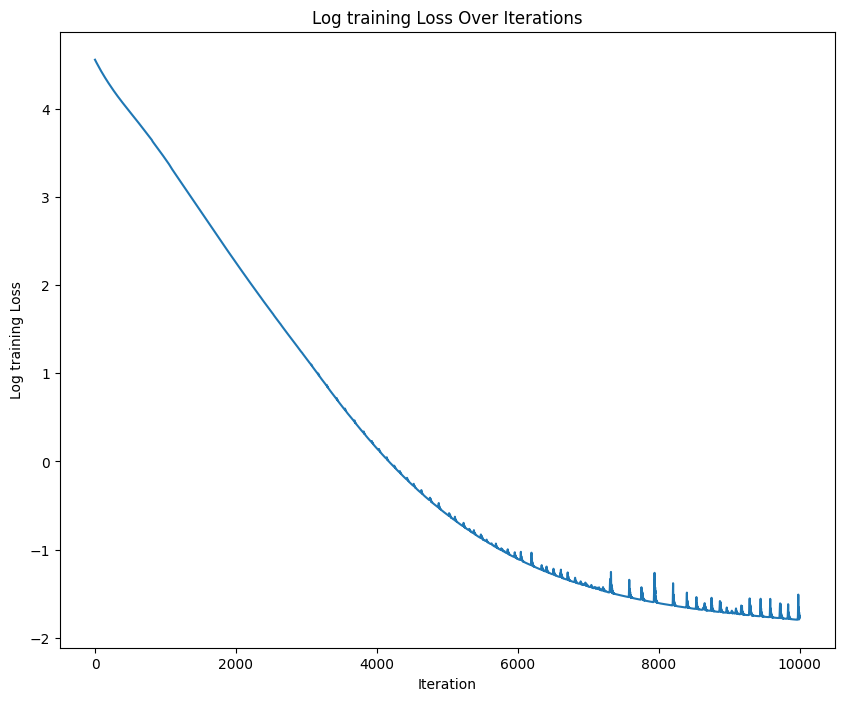

In [7]:
# Affichage de l'évolution de la perte d'entraînement
plt.figure(figsize=(10, 8))
plt.plot(np.log(train_loss_record))
plt.title("Log training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log training Loss")
plt.show()

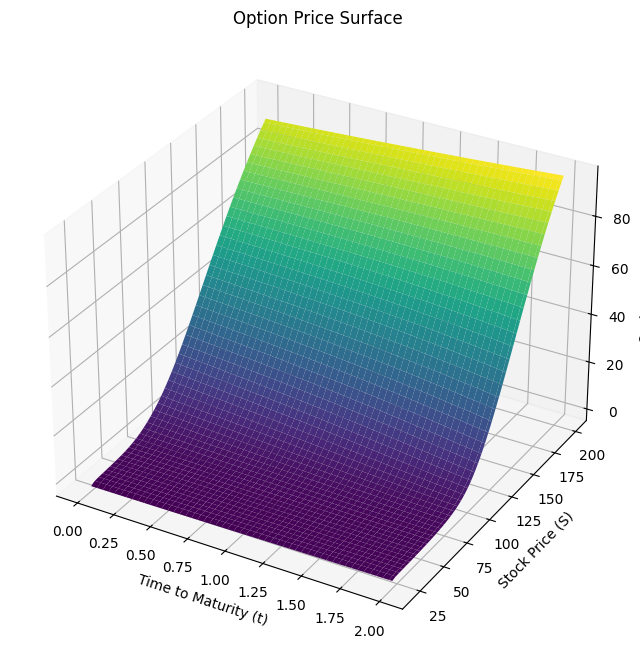

In [8]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Définir une grille de valeurs pour t et S
t_vals = torch.linspace(0, T, 100, device=device).view(-1, 1)
S_vals = torch.linspace(20, 200, 100, device=device).view(-1, 1)
t_grid, S_grid = torch.meshgrid(t_vals[:, 0], S_vals[:, 0], indexing='ij')
t_grid = t_grid.reshape(-1, 1)
S_grid = S_grid.reshape(-1, 1)

# Prédire les prix des options
with torch.no_grad(): 
    V_pred = model(t_grid, S_grid).cpu().reshape(100, 100)

# Créer un graphique en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
t_plot, S_plot = t_grid.cpu().reshape(100, 100), S_grid.cpu().reshape(100, 100)
ax.plot_surface(t_plot.numpy(), S_plot.numpy(), V_pred.numpy(), cmap='viridis')

ax.set_xlabel('Time to Maturity (t)')
ax.set_ylabel('Stock Price (S)')
ax.set_zlabel('Option Price (V)')
ax.set_title('Option Price Surface')
plt.show()

In [9]:
# Définir les entrées fixes
t_fixed = torch.tensor([[0.0]], device=device)  # Temps jusqu'à maturité
S_fixed = torch.tensor([[100]], device=device)  # Prix de l'action

# Prédire le prix de l'option d'achat
with torch.no_grad(): 
    V_pred = model(t_fixed, S_fixed)

print(f'Le prix prédit pour l\'option d\'achat est : {V_pred.item()}')

Le prix prédit pour l'option d'achat est : 16.571977615356445


In [10]:
def black_scholes_call(S0, K, r, sigma, T):
    """
    Calculates the price of a European call option using the Black-Scholes formula.

    Parameters:
    S0 (float): The current price of the underlying asset.
    K (float): The strike price of the option.
    r (float): The risk-free interest rate.
    sigma (float): The volatility of the underlying asset.
    T (float): The time to expiration of the option.

    Returns:
    float: The price of the call option.

    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    
    return call_price

In [11]:
black_scholes_call(100, 100, 0.05, 0.2, 2)

16.126779724978633